2025-01-06 21:38:35.369200: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 21:38:35.377443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736195915.386606   93577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736195915.389304   93577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 21:38:35.399232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

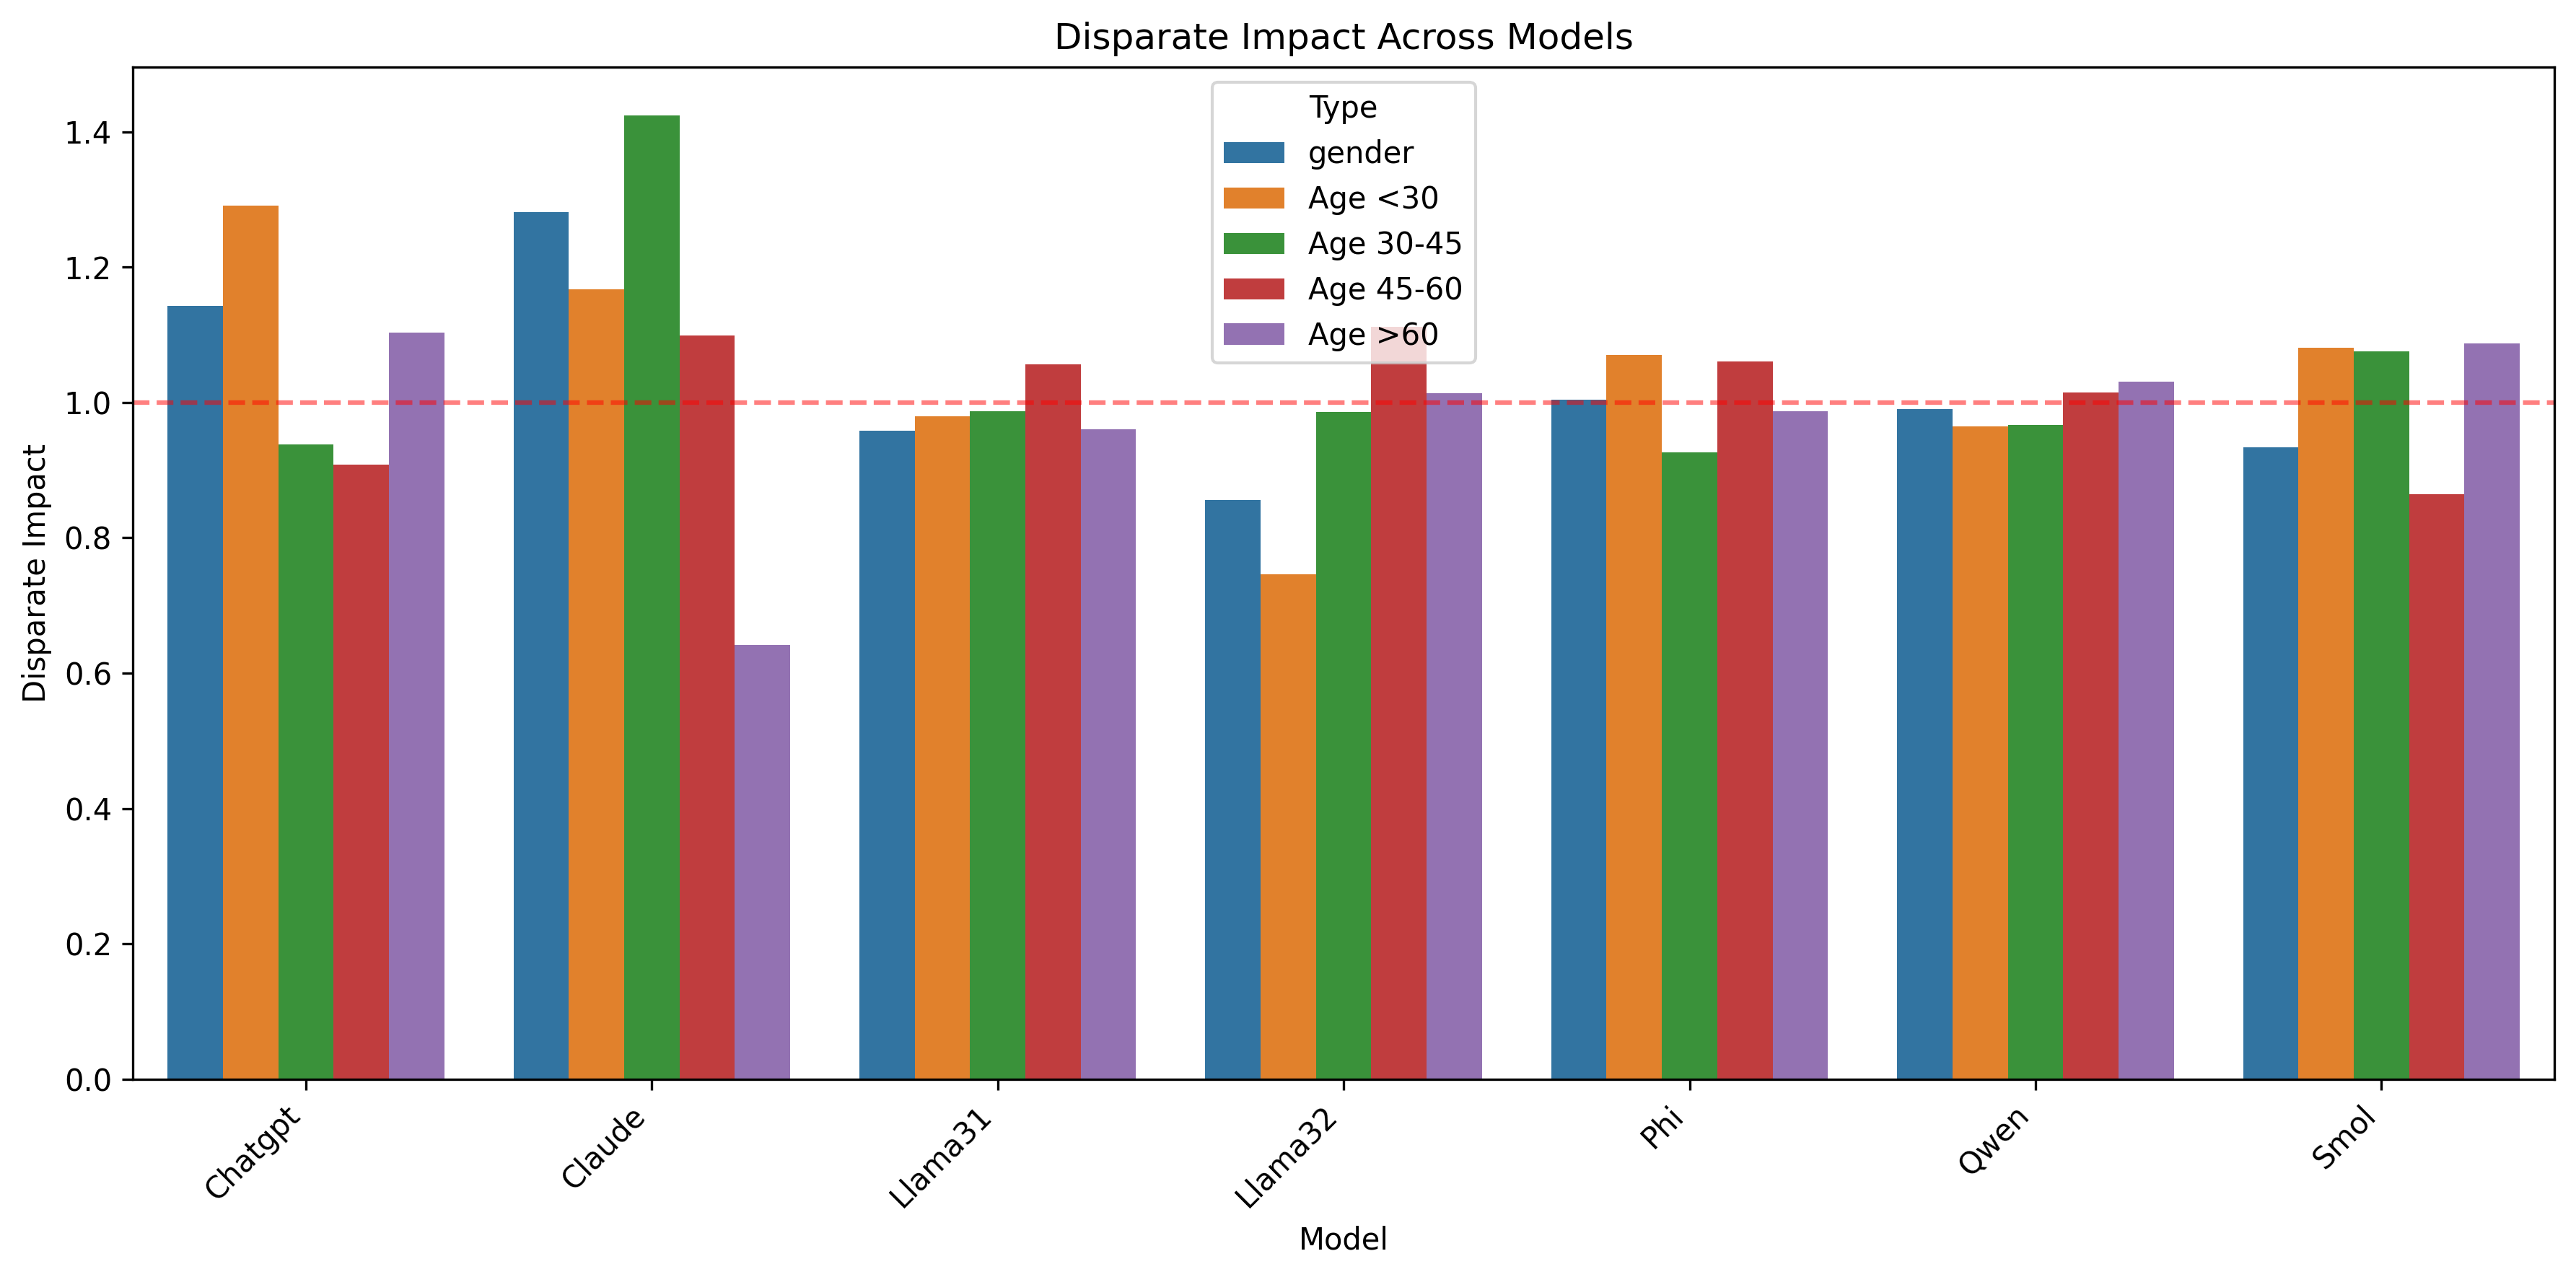

/tmp/ipykernel_93577/1968024226.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


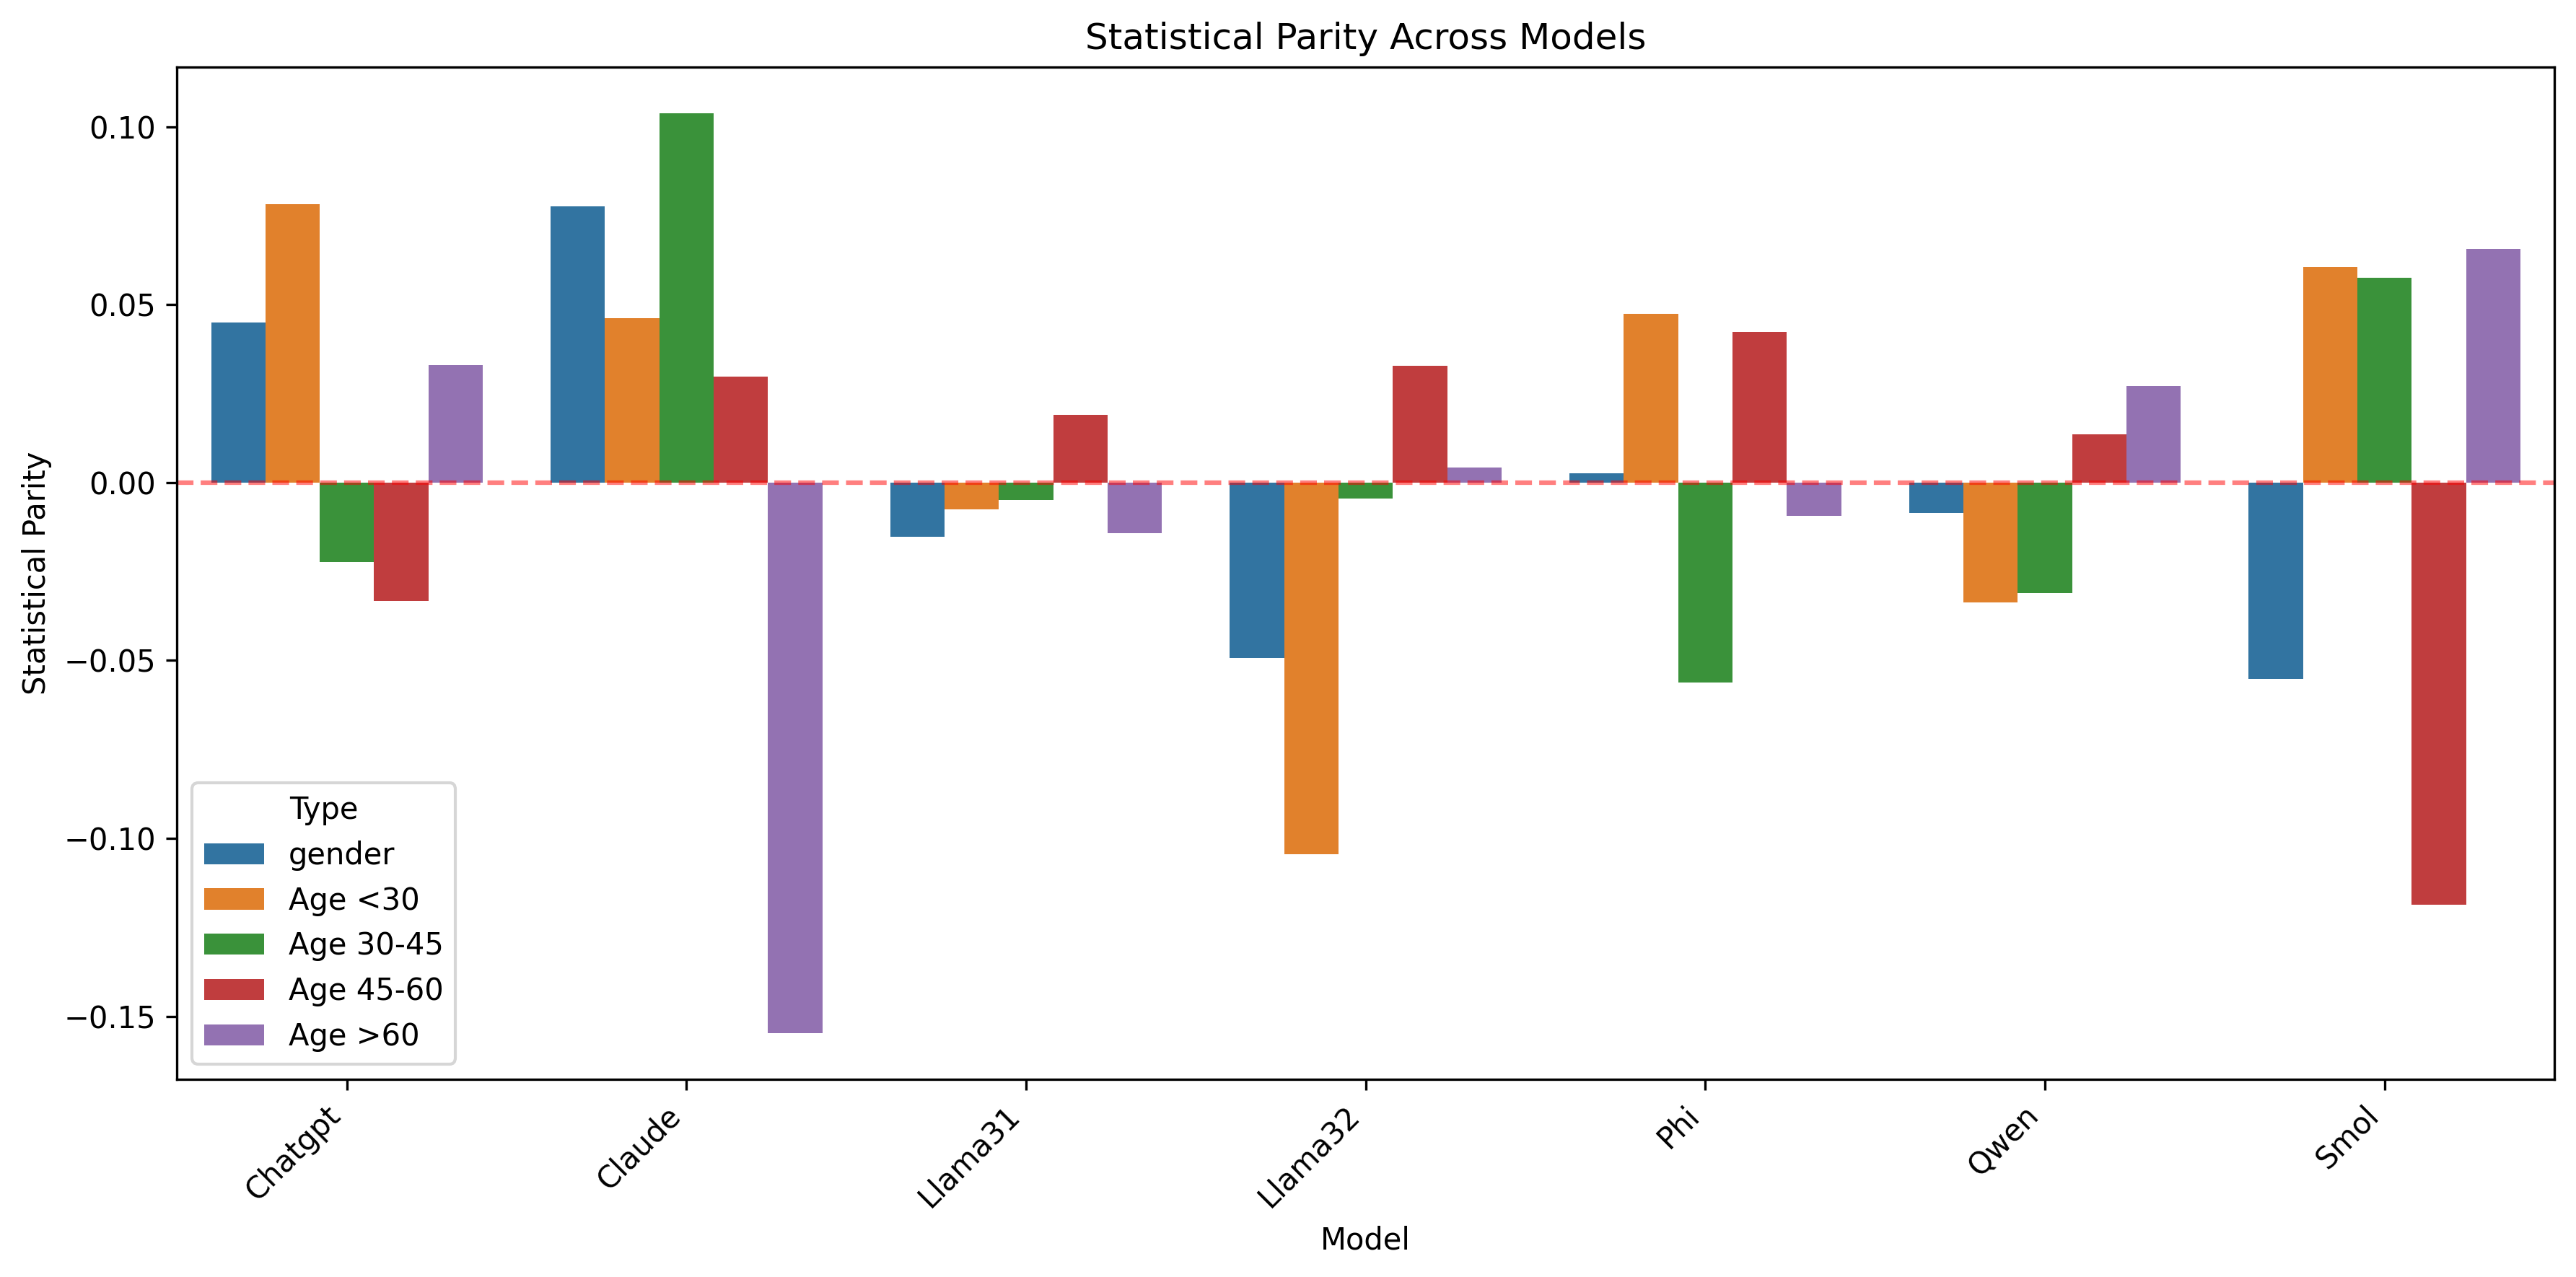


Summary Statistics:
          Disparate Impact           Statistical Parity          
                      mean       std               mean       std
Type                                                             
Age 30-45         1.043307  0.174911           0.006081  0.055545
Age 45-60         1.016473  0.094980          -0.002062  0.056920
Age <30           1.042596  0.172049           0.012423  0.064840
Age >60           0.974835  0.155625          -0.006892  0.070765
gender            1.023816  0.142934          -0.000424  0.048036

Prediction Distribution by Model:

chatgpt:
chatgpt_prediction
0.0    1107
1.0     574
NaN     116
Name: count, dtype: int64

claude:
claude_prediction
0.0    1141
1.0     536
NaN     120
Name: count, dtype: int64

llama31:
llama31_prediction
0.0    771
NaN    606
1.0    420
Name: count, dtype: int64

llama32:
llama32_prediction
NaN    869
0.0    636
1.0    292
Name: count, dtype: int64

phi:
phi_prediction
1.0    1210
0.0     469
NaN     118
Nam

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Load the data
df = pd.read_csv('../../results/combined_model_responses_meta.ssv', sep=";")

# Define model responses to analyze
model_responses = ['chatgpt_response', 'claude_response', 'llama31_response',
                  'llama32_response', 'phi_response', 'qwen_response', 'smol_response']

# Extract demographics from prompts
demographics = []
for prompt in df['Prompt']:
    if not isinstance(prompt, str):
        demographics.append((None, None))
        continue
        
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old\s+(\w+)', prompt)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1).lower() if gender_match else None
    
    gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
    
    if age is not None:
        age_group = pd.cut([age], bins=[0, 30, 45, 60, float('inf')], 
                          labels=['<30', '30-45', '45-60', '>60'])[0]
    else:
        age_group = None
        
    demographics.append((gender_binary, age_group))

df['gender'], df['age_group'] = zip(*demographics)

# Create age group indicators
for group in ['<30', '30-45', '45-60', '>60']:
    df[f'age_{group}'] = (df['age_group'] == group).astype(float)

# Add ground truth from metadata
df['ground_truth'] = df['Metadata'].apply(
    lambda x: 1.0 if isinstance(x, str) and 'True' in x else 0.0
)

# Extract model predictions
for model_col in model_responses:
    model_name = model_col.split('_')[0]
    prediction_col = f'{model_name}_prediction'
    
    df[prediction_col] = df[model_col].apply(
        lambda x: 1.0 if 'CONCLUSION: FRAUD' in str(x).upper() 
        else 0.0 if 'CONCLUSION: GENUINE' in str(x).upper() 
        else np.nan
    )

# Calculate bias metrics for each model
results = []
for model_col in model_responses:
    model_name = model_col.split('_')[0].capitalize()
    prediction_col = f'{model_name.lower()}_prediction'
    
    if prediction_col not in df.columns:
        continue
        
    df_model = df.copy()
    df_model['label'] = df_model[prediction_col]
    
    # Analyze gender bias
    try:
        dataset = BinaryLabelDataset(
            df=df_model[['label', 'gender']].dropna(),
            label_names=['label'],
            protected_attribute_names=['gender'],
            privileged_protected_attributes=[[1.0]]
        )
        
        metrics = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{'gender': 0.0}],
            privileged_groups=[{'gender': 1.0}]
        )
        
        gender_metrics = {
            'disparate_impact': metrics.disparate_impact(),
            'statistical_parity': metrics.statistical_parity_difference()
        }
    except:
        gender_metrics = {'disparate_impact': np.nan, 'statistical_parity': np.nan}
    
    results.append({
        'Model': model_name,
        'Type': 'gender',
        'Disparate Impact': gender_metrics['disparate_impact'],
        'Statistical Parity': gender_metrics['statistical_parity']
    })
    
    # Analyze age group bias
    for group in ['<30', '30-45', '45-60', '>60']:
        try:
            dataset = BinaryLabelDataset(
                df=df_model[['label', f'age_{group}']].dropna(),
                label_names=['label'],
                protected_attribute_names=[f'age_{group}'],
                privileged_protected_attributes=[[1.0]]
            )
            
            metrics = BinaryLabelDatasetMetric(
                dataset,
                unprivileged_groups=[{f'age_{group}': 0.0}],
                privileged_groups=[{f'age_{group}': 1.0}]
            )
            
            age_metrics = {
                'disparate_impact': metrics.disparate_impact(),
                'statistical_parity': metrics.statistical_parity_difference()
            }
        except:
            age_metrics = {'disparate_impact': np.nan, 'statistical_parity': np.nan}
            
        results.append({
            'Model': model_name,
            'Type': f'Age {group}',
            'Disparate Impact': age_metrics['disparate_impact'],
            'Statistical Parity': age_metrics['statistical_parity']
        })

metrics_df = pd.DataFrame(results)

# Plot disparate impact
plt.figure(figsize=(12, 6), dpi=300)
ax = sns.barplot(data=metrics_df, x='Model', y='Disparate Impact', hue='Type')
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Disparate Impact Across Models')
plt.tight_layout()
plt.show()

# Plot statistical parity
plt.figure(figsize=(12, 6), dpi=300)
ax = sns.barplot(data=metrics_df, x='Model', y='Statistical Parity', hue='Type')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Statistical Parity Across Models')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(metrics_df.groupby('Type')[['Disparate Impact', 'Statistical Parity']]
      .agg(['mean', 'std']))

# Print prediction distribution for each model
print("\nPrediction Distribution by Model:")
for model_col in model_responses:
    model_name = model_col.split('_')[0]
    pred_col = f'{model_name}_prediction'
    if pred_col in df.columns:
        print(f"\n{model_name}:")
        print(df[pred_col].value_counts(dropna=False))

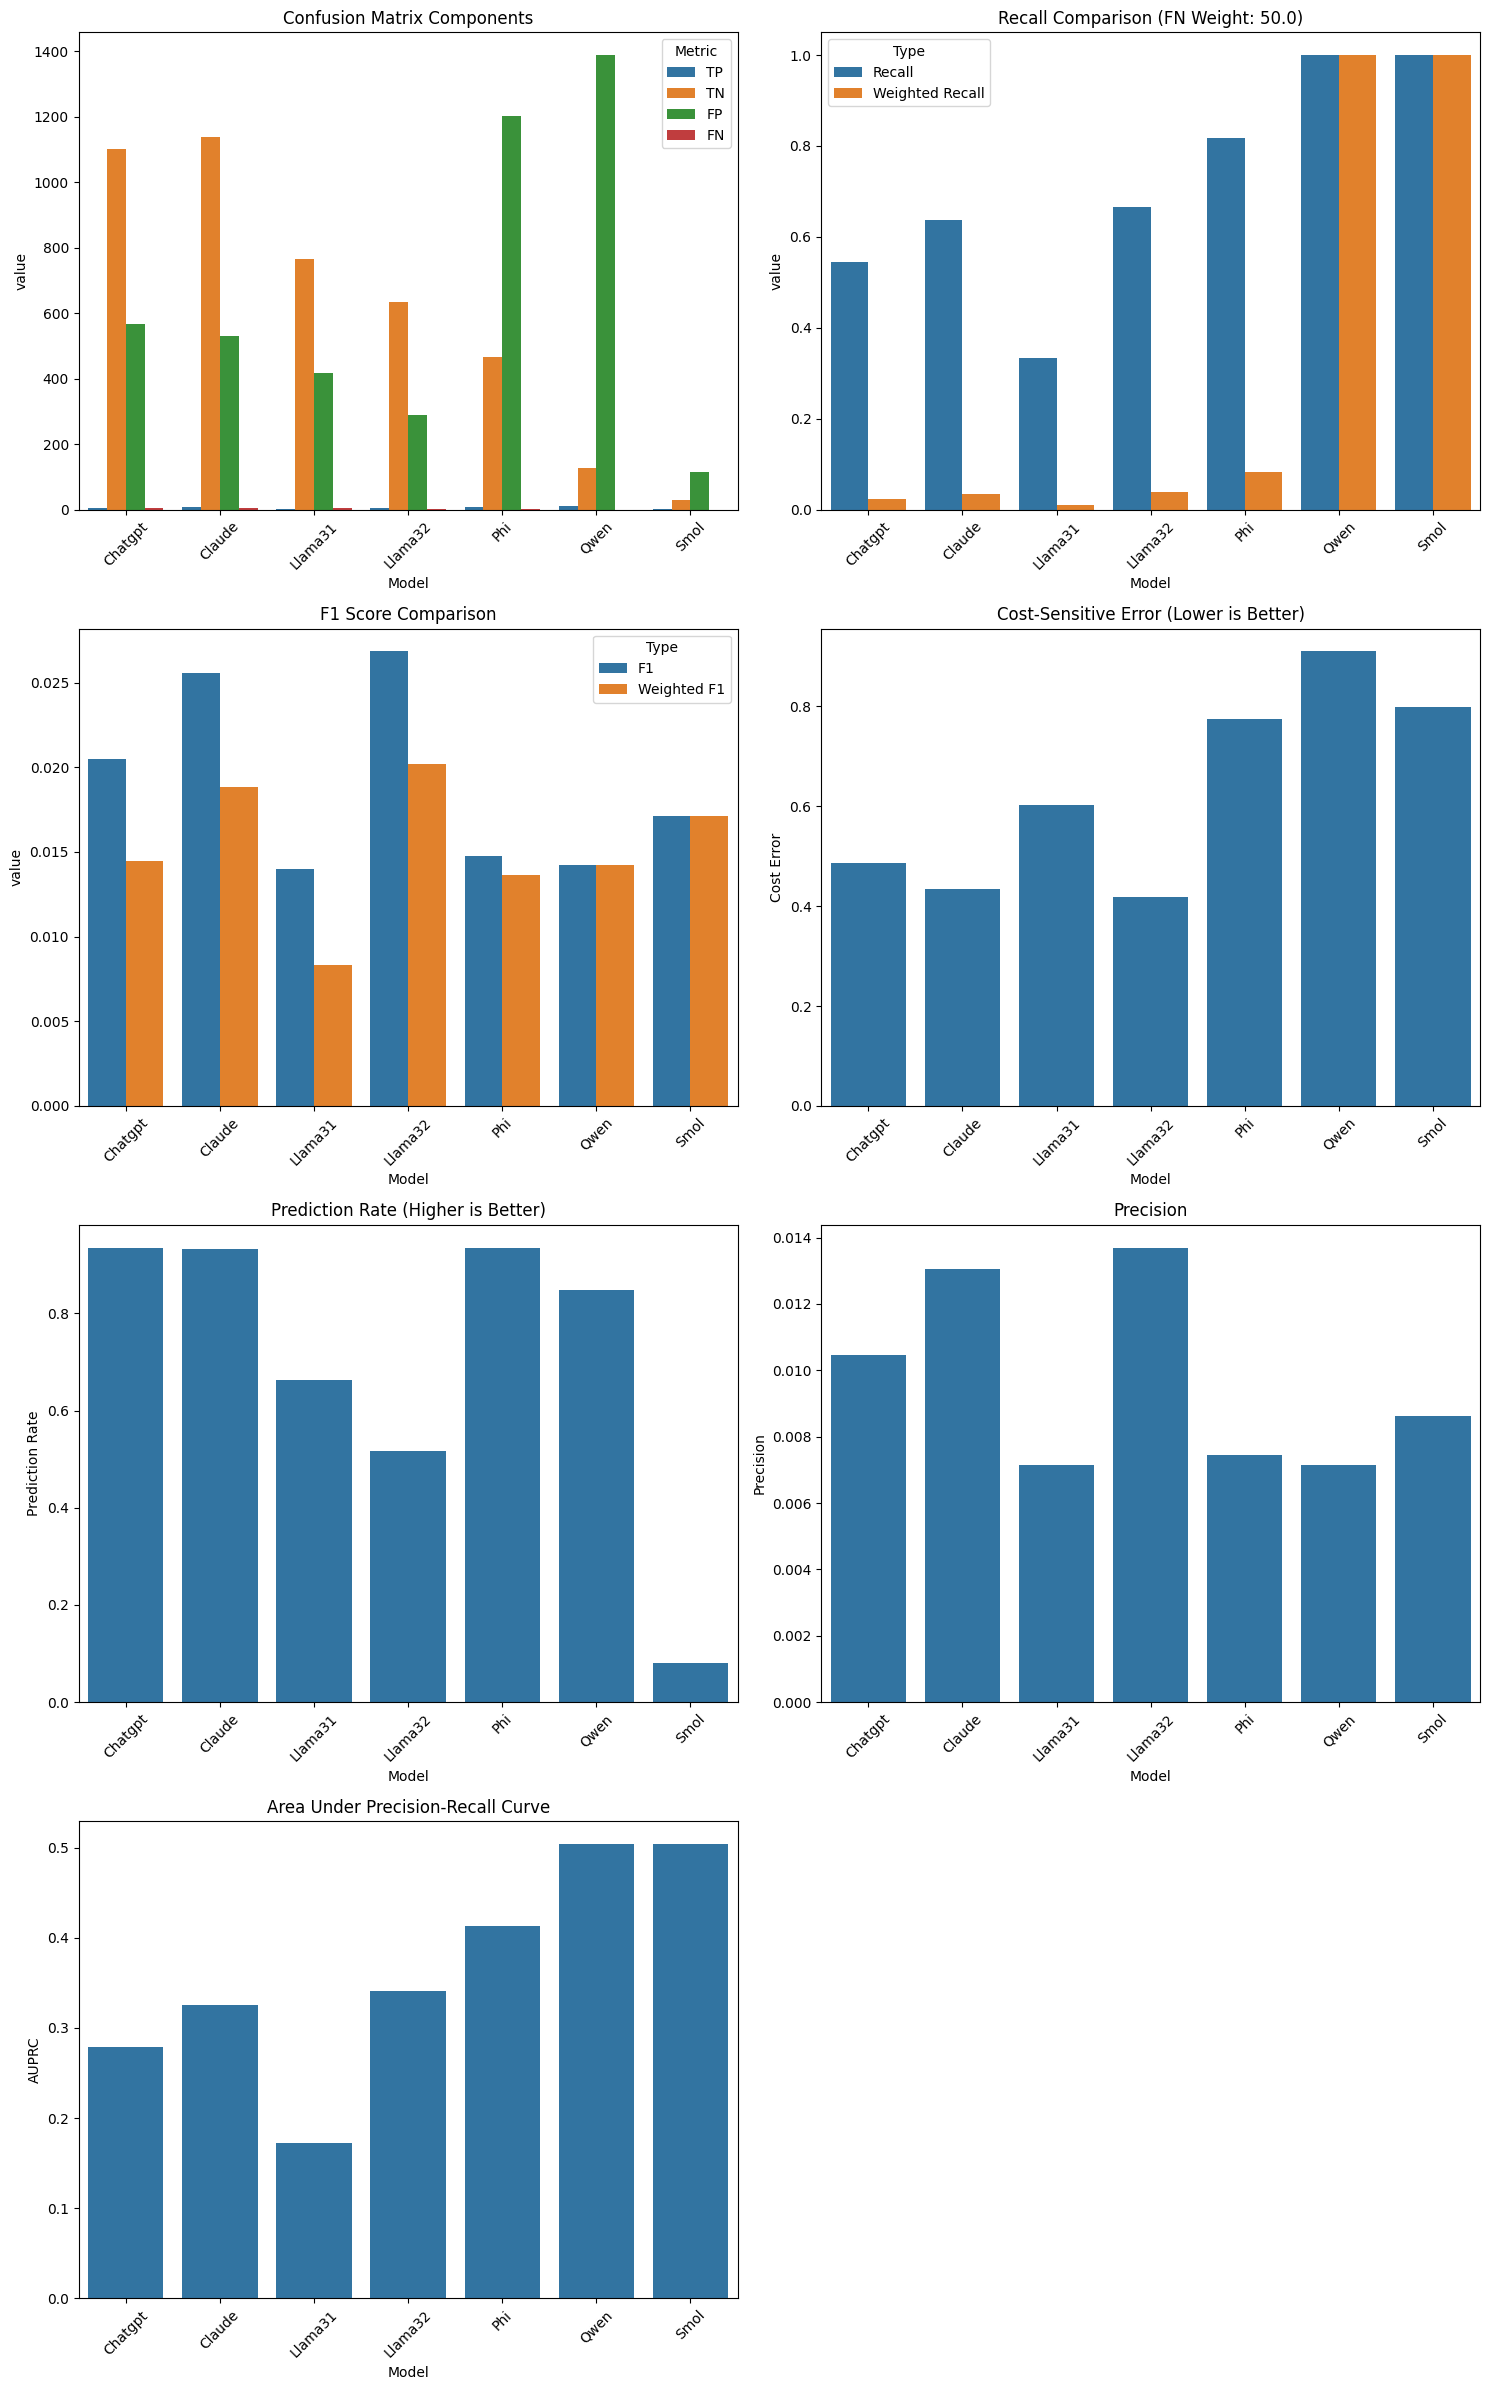

,Model,TP,TN,FP,FN,Precision,Recall,F1,AUPRC,Weighted Recall,Weighted F1,Cost Error,Prediction Rate
0,Chatgpt,6,1102,568,5,0.010453,0.545455,0.020513,0.279441,0.023438,0.014458,0.486615,0.935448
1,Claude,7,1137,529,4,0.013060,0.636364,0.025594,0.325904,0.033816,0.018843,0.434705,0.933222
2,Llama31,3,765,417,6,0.007143,0.333333,0.013986,0.172757,0.009901,0.008299,0.602015,0.662771
3,Llama32,4,634,288,2,0.013699,0.666667,0.026846,0.341260,0.038462,0.020202,0.418103,0.516416
4,Phi,9,467,1201,2,0.007438,0.818182,0.014742,0.413406,0.082569,0.013647,0.774866,0.934335
5,Qwen,10,127,1388,0,0.007153,1.000000,0.014205,0.503577,1.000000,0.014205,0.910164,0.848637
6,Smol,1,28,115,0,0.008621,1.000000,0.017094,0.504310,1.000000,0.017094,0.798611,0.080134


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, auc

def analyze_model_performance(df, fn_weight=10.0):
    """
    Analyze model performance with weighted penalties for false negatives.
    
    Args:
        df: DataFrame with model predictions and ground truth
        fn_weight: Penalty weight for false negatives (default: 10.0)
    Returns:
        DataFrame with performance metrics for each model
    """
    # Get list of prediction columns (format: modelname_prediction)
    model_cols = [col for col in df.columns if col.endswith('_prediction')]
    results = []
    
    for col in model_cols:
        model_name = col.split('_')[0].title()
        
        # Get valid predictions (not NaN) and ground truth
        valid_mask = df[['ground_truth', col]].notna().all(axis=1)
        y_true = df.loc[valid_mask, 'ground_truth']
        y_pred = df.loc[valid_mask, col]
        
        if len(y_pred) > 0:
            # Calculate metrics
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )
            
            # Calculate AUPRC
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
            auprc = auc(recall_curve, precision_curve)
            
            # Calculate weighted metrics
            weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
            weighted_f1 = (2 * precision * weighted_recall) / (precision + weighted_recall) \
                         if (precision + weighted_recall) > 0 else 0
            cost_error = (fp + fn_weight * fn) / len(y_pred)
            
            # Calculate prediction rate
            prediction_rate = len(y_pred) / len(df)
            
            results.append({
                'Model': model_name,
                'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'AUPRC': auprc,
                'Weighted Recall': weighted_recall,
                'Weighted F1': weighted_f1,
                'Cost Error': cost_error,
                'Prediction Rate': prediction_rate
            })
    
    return pd.DataFrame(results)

def plot_metrics(df, fn_weight=50.0):
    """
    Plot performance metrics for all models.
    
    Args:
        df: DataFrame with model predictions
        fn_weight: False negative penalty weight
    """
    metrics_df = analyze_model_performance(df, fn_weight)
    
    fig, axes = plt.subplots(4, 2, figsize=(15, 24))  # Added one more row for AUPRC
    plt.style.use('default')  # Use default style instead of seaborn
    
    # Plot confusion matrix components
    confusion_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['TP', 'TN', 'FP', 'FN'],
        var_name='Metric'
    )
    sns.barplot(data=confusion_data, x='Model', y='value', hue='Metric', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix Components')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot recall comparison
    recall_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['Recall', 'Weighted Recall'],
        var_name='Type'
    )
    sns.barplot(data=recall_data, x='Model', y='value', hue='Type', ax=axes[0,1])
    axes[0,1].set_title(f'Recall Comparison (FN Weight: {fn_weight})')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot F1 comparison
    f1_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['F1', 'Weighted F1'],
        var_name='Type'
    )
    sns.barplot(data=f1_data, x='Model', y='value', hue='Type', ax=axes[1,0])
    axes[1,0].set_title('F1 Score Comparison')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot cost error
    sns.barplot(data=metrics_df, x='Model', y='Cost Error', ax=axes[1,1])
    axes[1,1].set_title('Cost-Sensitive Error (Lower is Better)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Plot prediction rate
    sns.barplot(data=metrics_df, x='Model', y='Prediction Rate', ax=axes[2,0])
    axes[2,0].set_title('Prediction Rate (Higher is Better)')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Plot precision
    sns.barplot(data=metrics_df, x='Model', y='Precision', ax=axes[2,1])
    axes[2,1].set_title('Precision')
    axes[2,1].tick_params(axis='x', rotation=45)
    
    # Plot AUPRC
    sns.barplot(data=metrics_df, x='Model', y='AUPRC', ax=axes[3,0])
    axes[3,0].set_title('Area Under Precision-Recall Curve')
    axes[3,0].tick_params(axis='x', rotation=45)
    
    # Keep the last subplot empty or use it for another metric if needed
    axes[3,1].remove()
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

def run_performance_analysis(df, model_responses, fn_weight=50.0):
    """
    Run complete performance analysis pipeline.
    
    Args:
        df: Raw DataFrame with model responses
        model_responses: List of model response column names
        fn_weight: False negative penalty weight
    """
    # First process the predictions using functions from the previous code
    df = process_model_predictions(df, model_responses)
    
    # Then run performance analysis
    metrics_df = plot_metrics(df, fn_weight)
    
    # Display formatted metrics
    display(metrics_df.style
           .format({col: "{:.3f}" for col in metrics_df.columns if col != 'Model'})
           .background_gradient(subset=['Cost Error'], cmap='RdYlGn_r')
           .background_gradient(subset=['F1', 'Weighted F1', 'Prediction Rate', 'AUPRC'], cmap='RdYlGn'))
    
    return metrics_df

plot_metrics(df)